In [2]:
from loguru import logger
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-dark')
from time import time
from datetime import datetime
from tqdm import tqdm
import sparse
import psutil
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras import layers
# %load_ext tensorboard

# CONFIG

In [4]:
config={
    'data': {
        'dataset_filename':'../../ml/input/data/raw/M_A_dataset_twoweek_crm.csv',
        'csv_parsing_chunksize': 100000,
        'test_one_chunk':False,
        'only_from_order':False,
        'drop_aggsessions_from_dataframe': True,
        'drop_unique_paths_from_dataframe': False,
        'min_path_len':2, #only path lengths greater than 'min_path_len'
        'maximum_memory_usage':3000 #  in Mb 1000 = 1Gb
    },
    'preprocessing':{
        'maxlen_threshold':0.98,
        'downsampling' :False,
    },
    'attention':{
        'test_size':0.2,
        'max_features':5000,
        'embed_dim':64,
        'num_heads':2,
        'BATCH_SIZE':2048,
        'EPOCHS':20,
        'prob_threshold':0.5,
    }
}

# Util functions

In [6]:
def memory_footprint():
    mem = psutil.Process(os.getpid()).memory_info().rss
    return (mem / 1024 ** 2)
def pad_str_corpus(lst,maxlen):
    return (lst+ (maxlen-len(lst)) * [''])
def duplicates(lst, item):
    return [i for i, x in enumerate(lst) if x == item]
def time_decay(arr):
    return (np.nan_to_num(np.array([(max(arr) - elt)/60/60/24 for elt in arr])))  #  in days
flatten = lambda l: [item for sublist in l for item in sublist]

In [4]:
# filename='../../ml/input/data/raw/M_A_dataset_oneweek.csv'
# with open(filename, 'r') as f:
#     total_lines = sum(1 for line in f) - 1
# print('oneweek_df: ', total_lines)
# filename='../../ml/input/data/raw/M_A_dataset_oneday.csv'
# with open(filename, 'r') as f:
#     total_lines = sum(1 for line in f) - 1
# print('oneday_df: ', total_lines)

# Preprocessing in chunks

In [5]:
# Defining util functions
def crop_df_maxlen_threshold(df_s):
    cum_path=(df_s['utm_hash'].apply(len).value_counts().cumsum()/
                    df_s['utm_hash'].apply(len).value_counts().sum())
    (cum_path
    .plot(kind='bar',figsize=(8,6))
    )
    plt.title('path length', fontsize=40)
    plt.ylabel('cumulative percentage', size=20)
    plt.xlabel('path length',size=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.hlines(0.99, 0, cum_path.shape, colors='k', linestyles='dashed',lw=2)
    plt.show()
    maxlen=cum_path[cum_path<=config['preprocessing']['maxlen_threshold']].tail(1)
    print('MAXLEN :', maxlen)
    maxlen=maxlen.index[0]
    serie_to_use=df_s['utm_hash'].apply(len)<=cum_path[cum_path<=config['preprocessing']['maxlen_threshold']].index[-1]
#replotting
    df_s=df_s[serie_to_use]
    cum_path=(df_s['utm_hash'].apply(len).value_counts().cumsum()/
                    df_s['utm_hash'].apply(len).value_counts().sum())
    (cum_path
    .plot(kind='bar',figsize=(8,6))
    )
    plt.title('Dropped path length', fontsize=40)
    plt.ylabel('cumulative percentage', size=20)
    plt.xlabel('path length',size=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.hlines(0.99, 0, cum_path.shape, colors='k', linestyles='dashed',lw=2)
    plt.show()
    return serie_to_use,maxlen,cum_path
def time_decay(arr):
#     return np.nan_to_num(np.array([(max(arr) - elt)/(max(arr)-min(arr)) for elt in arr]))
    return (np.nan_to_num(np.array([(max(arr) - elt)/60/60/24 for elt in arr])))  #  in days
def memory_footprint():
    mem = psutil.Process(os.getpid()).memory_info().rss
    return (mem / 1024 ** 2)

In [6]:
# import pandas as pd
# filename='../../ml/input/data/raw/M_A_dataset_twoweek_fb.csv'
# def teste():
#     df_iterator=pd.read_csv(filename, chunksize=100000)
#     for chunk in df_iterator:
#         return chunk
# df_c=teste()
# df_c['agg_sessions']=df_c['agg_sessions'].str.split(';')
# df_c=df_c.explode('agg_sessions')
# df_c['agg_sessions']=df_c['agg_sessions'].str.split(':')

# df_c

In [7]:
def load_and_preprocess_dataframe(config=config):
    t0=time()
    filename = config['data']['dataset_filename']
    chunksize = config['data']['csv_parsing_chunksize']
    drop_aggsessions = config['data']['drop_aggsessions_from_dataframe']
    test_one_chunk=config['data']['test_one_chunk']
    only_from_order=config['data']['only_from_order']
    maximum_memory_usage=config['data']['maximum_memory_usage']
    drop_unique_paths_from_dataframe=config['data']['drop_unique_paths_from_dataframe']
    min_path_len=config['data']['min_path_len']  
    print('Calculating chunks...')
# '''Returns memory (in MB) being used by Python process'''
    with open(filename, 'r') as f:
        total_lines = sum(1 for line in f) - 1
    num_chunks = int(np.ceil(total_lines/chunksize))
    print(f'Dataset name: {filename}')
    print(f'Chunck size: {chunksize}.\nTotal number of chunks: {num_chunks}')
    print('\nImporting dataset...')
    df_iterator = pd.read_csv(filename, chunksize=chunksize)
    corpus = []
    df_s = pd.DataFrame()
    df_con= pd.DataFrame()
    original_shape=0
    dropped_shape=0
    for df_c in tqdm(df_iterator, total=num_chunks):
#CUSTOMER PATH
# Exploding sessions
        df_c['agg_sessions']=df_c['agg_sessions'].str.split(';')
        df_c=df_c.explode('agg_sessions')
        df_c['agg_sessions']=df_c['agg_sessions'].str.split(':')
        # get parameters from agg_sessions
# creating columns spliting session informations
        df_c['utm_hash']=df_c['agg_sessions'].apply(lambda x: x[0]).str.split(',')
        df_c['sess']=df_c['agg_sessions'].apply(lambda x: np.fromstring(x[1],dtype=int,sep=(','))).apply(lambda x: time_decay(x))
        df_c['trinomials']=df_c['agg_sessions'].apply(lambda x: x[2]).str.replace(' ','').str.replace('1','kwDft').str.replace('0','nokwDft').str.split(',')
        df_c['value']=df_c['agg_sessions'].apply(lambda x: np.fromstring(x[3],dtype=float,sep=(',')))
        df_c=df_c.drop(['agg_cvg','agg_sessions'],axis=1)
        df_s=df_s.append(df_c)     
        del df_c
        if test_one_chunk:
            print(f'Just one chunk to analyse')
            break
        if memory_footprint()>maximum_memory_usage:
            print('Broken by memmory footprint')
            print(memory_footprint())
            break
    serie_to_use,maxlen,_=crop_df_maxlen_threshold(df_s)
    df_s=df_s[serie_to_use]
    df_con=(df_s[['gid','country_region','gender','birthday','cust_created_year']])
    df_s=df_s.drop(['gid','country_region','gender','birthday','cust_created_year'],axis=1)
    corpus=df_s['utm_hash'].to_list()
    y=(df_s['value']>0).values.astype(int)
    print(f'Final Dataframe shape {df_s.shape}')
    print(f'Done! {np.round((time()-t0)/60,2)} min spent')
    return df_s,df_con,corpus,y,maxlen

Calculating chunks...


  0%|          | 0/114 [00:00<?, ?it/s]

Dataset name: ../../ml/input/data/raw/M_A_dataset_twoweek_crm.csv
Chunck size: 100000.
Total number of chunks: 114

Importing dataset...


 18%|█▊        | 20/114 [02:10<10:11,  6.50s/it]

Broken by memmory footprint
3097.1640625


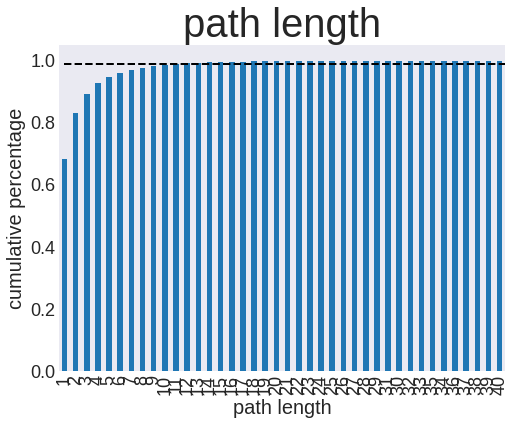

MAXLEN : 8    0.976481
Name: utm_hash, dtype: float64


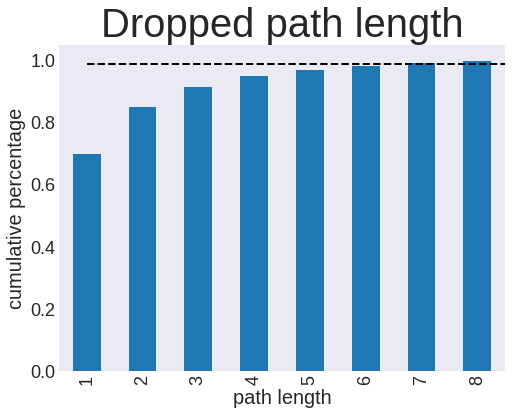

Final Dataframe shape (2114379, 4)
Done! 2.34 min spent


In [8]:
df_s,df_con,corpus,y,maxlen=load_and_preprocess_dataframe(config)
# _,df_con,_,_,_=load_and_preprocess_dataframe(config)

In [9]:
print(df_s.shape,df_con.shape)

(2114379, 4) (2114379, 5)


In [10]:
df_s.head()
df_s[df_s['utm_hash'].isna()]

,utm_hash,sess,trinomials,value


In [11]:
# df_s[(df_con['gid'].str.contains(':')) &( df_s['value']>0)].shape[0]
df_con[df_s['value']==0]['gender'].value_counts()

not_set    1715073
female      251403
male         69069
Name: gender, dtype: int64

In [12]:
df_s.head()

,utm_hash,sess,trinomials,value
0,[469d22463e819fe96ec507547f7c1c55],[0.0],[google_cpc_nokwDft],[0.0]
1,[ac5bcd5526b865dda8399ee9ea0805c7],[0.0],[kwDft29424kwDft759_af_nokwDft],[0.0]
2,[46aedd9f727b7f29bcb2308f3276436b],[0.0],[prospecting_dp_nokwDft],[0.0]
3,"[9f3d23b2254910561e1778450e4b3d13, 9f3d23b2254...","[3.7871064814814814, 0.0]","[google_organic_nokwDft, google_organic_nokwDft]",[0.0]
4,[68284d2fe147e66017e61b51063c9b7f],[0.0],[google_cpc_kwDft],[1.0]


# Preparing as NLP
Tokenization, and Padding sequences

In [13]:
config['attention']['max_features']

5000

In [14]:
# maxlen=19
# config['attention']['max_features']=2000
tk = Tokenizer(num_words=config['attention']['max_features'], split=',')
tk.fit_on_texts(corpus)
X = tk.texts_to_sequences(corpus)
seqleng=np.array([len(l) for l in X])
zeroseq=(seqleng[seqleng==0]).shape[0]
logger.info(f'lost sequences: {(zeroseq)/len(X)}')
X = pad_sequences(X, maxlen=maxlen,padding='post') # customer path
TD=pad_sequences(df_s['sess'].values,maxlen=maxlen,dtype='float32',padding='post') # time decay from sessions
# C=pd.get_dummies(df_con.drop('client_id',axis=1), columns=['country_region', 'cg', 'gender', 'age_gp', 'cust_created_years_gp']).values# customer dependet variables
C=pd.get_dummies(df_con.drop('gid',axis=1), columns=['country_region', 'gender']).values# customer dependet 
vocab_size = len(tk.word_counts)+1
print('\n Total vocabulary size: ',vocab_size)
embed_dim=config['attention']['embed_dim']
print(f'\n Embeding dim {embed_dim} - sqrt vocab_size {np.ceil(np.sqrt(vocab_size))}')
# saving
with open('../../ml/model/attention_model/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tk, handle)
Ccols=pd.get_dummies(df_con.drop('gid',axis=1), columns=['country_region', 'gender']).columns
# pd.get_dummies(df_con.drop('client_id',axis=1), columns=['country_region', 'cg', 'gender', 'age_gp', 'cust_created_years_gp']).columns
Ccols=list(Ccols.values)
# # TEST SET PREPROCESSING
# X_test=tk.texts_to_sequences(corpus_test)
# X_test = pad_sequences(X_test, maxlen=maxlen,padding='post') # customer path
# TD_test=pad_sequences(df_s_test['sess'].values,maxlen=maxlen,dtype='float32',padding='post') # time decay from sessions
# cols=pd.get_dummies(df_con.drop('client_id',axis=1), columns=['country_region', 'cg', 'gender', 'age_gp', 'cust_created_years_gp']).columns
# C_test=pd.DataFrame(columns=cols) #to C_test to have same dimensions of C_train
# C_test=C_test.append(pd.get_dummies(df_con_test.drop('client_id',axis=1), columns=['country_region', 'cg', 'gender', 'age_gp', 'cust_created_years_gp']))
# C_test=C_test.fillna(0)
# Generate cumulative tokenization dataframe
cum_tk_df=pd.DataFrame.from_dict(dict(tk.word_counts),orient='index',columns=['cnt'])
cum_tk_df=cum_tk_df.sort_values(by='cnt',ascending=False)
cum_tk_df['ratio']=cum_tk_df/cum_tk_df.sum()
cum_tk_df['cum_sum']=cum_tk_df['ratio'].cumsum()
cum_tk_df.reset_index(inplace=True)
cum_tk_df=cum_tk_df.rename(columns={"index": "medium"})
cum_tk_df['rank']=cum_tk_df.index
vocab_size = len(tk.word_counts)+1
print('\nFive most important medium \n:',cum_tk_df.head())
print('\n Total vocabulary size: ',vocab_size)
embed_dim=config['attention']['embed_dim']
print(f'\n Embeding dim {embed_dim} - sqrt vocab_size {np.ceil(np.sqrt(vocab_size))}')
# word_index = tk.word_index

2021-01-07 10:02:31.824 | INFO     | __main__:<module>:8 - lost sequences: 0.07961155497666218



 Total vocabulary size:  147123

 Embeding dim 64 - sqrt vocab_size 384.0

Five most important medium 
:                              medium     cnt     ratio   cum_sum  rank
0  42b4c899c39ac03cc595b36e8a618951  563740  0.162617  0.162617     0
1  4f5445efbd48f8c8405addb9e3e6818e  351475  0.101387  0.264004     1
2  9f3d23b2254910561e1778450e4b3d13  214779  0.061955  0.325959     2
3  b88429773d4a0d05c8454d25386b404d   64445  0.018590  0.344549     3
4  dd3df59d484165047fee545be6c90851   59560  0.017181  0.361730     4

 Total vocabulary size:  147123

 Embeding dim 64 - sqrt vocab_size 384.0


In [15]:
num_words=config['attention']['max_features']
print(f'\n Fraction of vocabulary represented: {num_words/vocab_size}')
print(f'\n Embeding dim {embed_dim} - sqrt vocab_size {np.ceil(np.sqrt(num_words))}')


 Fraction of vocabulary represented: 0.03398516887230413

 Embeding dim 64 - sqrt vocab_size 71.0


In [16]:
# config['attention']['embed_dim']=64
# print(cum_tk_df.loc[])
cum_tk_df[cum_tk_df['rank']<num_words]['cum_sum'].tail(1).values

array([0.89996143])

In [17]:
# config['attention']['max_features']
cum_tk_df[cum_tk_df['rank']<num_words].head(3000)

,medium,cnt,ratio,cum_sum,rank
0,42b4c899c39ac03cc595b36e8a618951,563740,0.162617,0.162617,0
1,4f5445efbd48f8c8405addb9e3e6818e,351475,0.101387,0.264004,1
2,9f3d23b2254910561e1778450e4b3d13,214779,0.061955,0.325959,2
3,b88429773d4a0d05c8454d25386b404d,64445,0.018590,0.344549,3
4,dd3df59d484165047fee545be6c90851,59560,0.017181,0.361730,4
...,...,...,...,...,...
2995,b1a9e4dbe79fe079e064bd11a34d6abc,42,0.000012,0.882007,2995
2996,38835f1c19037f88e5bba248e0a05bb1,42,0.000012,0.882019,2996
2997,ff91a3e705f0831a18c8ddb82661f3e7,42,0.000012,0.882031,2997
2998,83c14a43a513d2dcb1f533f87cf99b3b,42,0.000012,0.882043,2998


### Ttrain_test_split

In [18]:
# tr_idx,te_idx,y_train,y_test=train_test_split(np.arange(X.shape[0]), y, test_size=config['attention']['test_size'],stratify=y)
# X_train,X_test=X[tr_idx],X[te_idx]
# TD_train,TD_test=TD[tr_idx],TD[te_idx]
# C_train,C_test=C[tr_idx],C[te_idx]
# tr_idx,val_idx,y_train,y_val=train_test_split(np.arange(X_train.shape[0]), y_train, test_size=config['attention']['test_size'],stratify=y_train)
# X_train,X_val=X_train[tr_idx],X_train[val_idx]
# TD_train,TD_val=TD_train[tr_idx],TD_train[val_idx]
# C_train,C_val=C_train[tr_idx],C_train[val_idx]
tr_idx,val_idx,y_train,y_val=train_test_split(np.arange(X.shape[0]), y, test_size=config['attention']['test_size'],stratify=y)
X_train,X_val=X[tr_idx],X[val_idx]
TD_train,TD_val=TD[tr_idx],TD[val_idx]
C_train,C_val=C[tr_idx],C[val_idx]

In [19]:
if config['preprocessing']['downsampling']:
# Downsampling function
    def downsampler(X,TD,C,y):
        cvsize=(np.where(y==1)[0]).shape[0]
        X0=(X[y==0][:cvsize])
        X1=(X[y==1])
        TD0=(TD[y==0][:cvsize])
        TD1=(TD[y==1])
        C0=(C[y==0][:cvsize])
        C1=(C[y==1])
        y0=np.zeros(X0.shape[0])
        y1=np.ones(X1.shape[0])
        X=np.vstack((X0,X1))
        TD=np.vstack((TD0,TD1))
        C=np.vstack((C0,C1))
        y=np.hstack((y0,y1))
        return X,TD,C,y
#Training set
    X_train,TD_train,C_train,y_train=downsampler(X_train,TD_train,C_train,y_train)
# Validation set
    X_val,TD_val,C_val,y_val=downsampler(X_val,TD_val,C_val,y_val)

Training classes ratio 0.03708713493266048
Validation classes ratio 0.03708652181727031


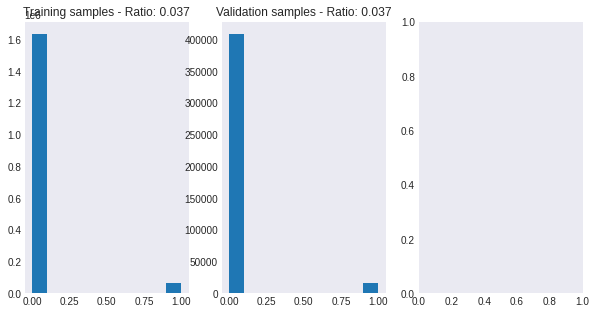

In [20]:
print('Training classes ratio',y_train.sum()/y_train.shape[0])
print('Validation classes ratio',y_val.sum()/y_val.shape[0])
# print('Test classes ratio',y_test.sum()/y_test.shape[0])
# del df_s
fig,(ax0,ax1,ax2)= plt.subplots(1,3,figsize=(10,5))
ax0.hist(y_train)
ax0.set_title('Training samples - Ratio: ' + str(np.round(y_train.sum()/y_train.shape[0],3)))
ax1.hist(y_val)
ax1.set_title('Validation samples - Ratio: ' + str(np.round(y_val.sum()/y_val.shape[0],3)))
# ax2.hist(y_test)
# ax2.set_title('Test samples - Ratio: ' + str(np.round(y_test.sum()/y_test.shape[0],3)))
plt.show()

In [21]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
neg=y_train.shape[0]-y_train.sum()
pos=y_train.sum()
total=y_train.shape[0]
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0 - Non_conversion path: {:.2f}'.format(weight_for_0))
print('Weight for class 1 - Conversion path: {:.2f}'.format(weight_for_1))

Weight for class 0 - Non_conversion path: 0.52
Weight for class 1 - Conversion path: 13.48


In [22]:
print('Training features shape:', X_train.shape)
print('Validation features shape:', X_val.shape)
# print('Test features shape:', X_test.shape)

print('\nTraining labels shape:', y_train.shape)
print('Validation labels shape:', y_val.shape)
# print('Test labels shape:', y_test.shape)

Training features shape: (1691503, 8)
Validation features shape: (422876, 8)

Training labels shape: (1691503,)
Validation labels shape: (422876,)


# DNN-Atention

##  DNN layers

In [9]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super(TokenAndPositionEmbedding, self).__init__()
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
#         super(TokenAndPositionEmbedding, self).__init__(**kwargs)
        
    def get_config(self):
        config = super(TokenAndPositionEmbedding, self).get_config()
        config.update({
            'maxlen': self.maxlen,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim,
            'token_emb': layers.Embedding(
                input_dim=self.vocab_size,
                output_dim=self.embed_dim
            ),
            'pos_emb': layers.Embedding(
                input_dim=self.maxlen,
                output_dim=self.embed_dim
            )
        })
        return config
    
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [11]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=4,**kwargs):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}")
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)
#         super(MultiHeadSelfAttention, self).__init__(**kwargs)

    def get_config(self):
        config = super(MultiHeadSelfAttention, self).get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'projection_dim': self.embed_dim // self.num_heads,
            'query_dense': layers.Dense(self.embed_dim),
            'key_dense': layers.Dense(self.embed_dim),
            'value_dense': layers.Dense(self.embed_dim),
            'combine_heads': layers.Dense(self.embed_dim)
        })
        return config
    
    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(query, batch_size)  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(key, batch_size)  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(value, batch_size)  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(concat_attention)  # (batch_size, seq_len, embed_dim)
        return output, weights

In [25]:
# Defining nützlich functions
def plot_metrics(history):
    METRICS = [s for s in list(history.history.keys()) if not "val" in s]
    plt.rcParams['figure.figsize'] = (12, 10)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']    
    for n, metric in enumerate(METRICS):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(np.ceil(len(METRICS)/2).astype(int),2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
              color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.legend()
        
def plot_cm(labels, predictions, p=config['attention']['prob_threshold']):
    if predictions.shape[1]>1:
        predictions=((predictions>p)[:,1]).astype(int)
        cm = confusion_matrix(labels, predictions)
    else:
        cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('No-conversion Detected (True Negatives): ', cm[0][0])
    print('No-conversion Incorrectly Detected (False Positives): ', cm[0][1])
    print('Convertions Missed (False Negatives): ', cm[1][0])
    print('Convertions Detected (True Positives): ', cm[1][1])
    print('Total No-conversions: ', np.sum(cm[0]))
    print('Total conversions: ', np.sum(cm[1]))
    print('Total conversions/No-conversions: ', np.sum(cm[1])/np.sum(cm[0]))
    print('Precision:',(cm[1][1])/(cm[1][1]+cm[0][1]))
    print('True Negative Rate',np.sum(cm[0][0])/np.sum(cm[0]))
    print('True Positive Rate',np.sum(cm[1][1])/np.sum(cm[1]))
    

## Make and train model

In [20]:
def f1_metric(y_true, y_pred):
    K=tf.keras.backend
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [27]:
def make_model_t(embed_dim=10,num_heads=1,num_words=2000,**kwargs):
    METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
      f1_metric,
    ]
    if kwargs.get('cus_dep_shape'):
        cus_dep_shape=kwargs.get('cus_dep_shape')
    else: cus_dep_shape=np.nan
#  UTIL LAYERS
    embedding_layer = TokenAndPositionEmbedding(maxlen, num_words, embed_dim)
    attention_layer=MultiHeadSelfAttention(embed_dim, num_heads)
#     PATH INPUTS
    path_layer=layers.Input(shape=(maxlen,), dtype='int32',name='input_path')
    x = embedding_layer(path_layer)
#     x=layers.LSTM(embed_dim,return_sequences=True,unroll=True,name='LSTM_path')(x)
    x,weights = attention_layer(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="relu",name='Dense_path')(x)
#     TIME-DECAY INPUTS
    td_layer = layers.Input(shape=(maxlen,), dtype='float32', name='input_timedecay')
    td = embedding_layer(td_layer)
#     td=layers.LSTM(maxlen,return_sequences=True,unroll=True,name='LSTM_td')(td_layer)
    # td=layers.LSTM(embed_dim,return_sequences=True,unroll=True,name='LSTM_td')(td)
    td,_ = attention_layer(td)
    td = layers.GlobalAveragePooling1D()(td)
    td = layers.Dropout(0.1)(td)
    td = layers.Dense(64, activation="relu",name='Dense_td')(td)
#     Concatenate path and time decay
    x_td=layers.Concatenate()([x,td])
    x_td = layers.Dropout(0.1)(x_td)
#     CUSTOMER-DEPENDENT INPUTS
    cd_input=layers.Input(shape=(cus_dep_shape,), dtype='int32',name='input_cd')
    cd = layers.Dense(64, activation="relu",name='Dense_customer1')(cd_input)
    cd = layers.Dropout(0.1)(cd)
    cd = layers.Dense(32, activation="relu",name='Dense_customer2')(cd)
    cd = layers.Dropout(0.1)(cd)
#     OUPUTS
    x_td_cd=layers.Concatenate()([x_td,cd])
    outputs = layers.Dense(1, activation="sigmoid")(x_td_cd)
    
    model = Model(inputs=[path_layer,td_layer,cd_input], outputs=outputs)
    opt = tf.keras.optimizers.Nadam()
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=METRICS)
    print(model.summary())
    return model

In [28]:
C.shape[-1]

34

In [29]:
config['attention']['max_features']

5000

In [30]:
# print('Embedding dimesions: ', (config['attention']['embed_dim']), '- total vocab size :', vocab_size, '- used vocab size:', config['attention']['max_features'])
# print('Number of attention heads: ', config['attention']['num_heads'])
model=make_model_t(
                embed_dim=config['attention']['embed_dim']
                ,num_heads=config['attention']['num_heads']
                ,num_words=config['attention']['max_features']
                ,cus_dep_shape=C.shape[-1]
                )

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_path (InputLayer)         [(None, 8)]          0                                            
__________________________________________________________________________________________________
input_timedecay (InputLayer)    [(None, 8)]          0                                            
__________________________________________________________________________________________________
token_and_position_embedding (T (None, 8, 64)        320512      input_path[0][0]                 
                                                                 input_timedecay[0][0]            
__________________________________________________________________________________________________
multi_head_self_attention (Mult ((None, None, 64), ( 16640       token_and_position_embedding[

In [64]:
# print('MODEL INPUTS \n')
# [print(i.shape, i.dtype) for i in model.inputs]
# print('MODEL OUTPUTS \n')
# [print(o.shape, o.dtype) for o in model.outputs]
# print('MODEL LAYERS \n')
# [print(l.name, '*', l.input_shape, '*', l.dtype) for l in model.layers]

In [31]:
print('Batch size: ', config['attention']['BATCH_SIZE'])
print('Epochs: ', config['attention']['EPOCHS'])
logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_recall',min_delta=0.02,patience=3,
                                                mode='max',restore_best_weights=False,verbose=1)
historymh= model.fit([X_train,TD_train,C_train],y_train.astype(int),
                    batch_size=config['attention']['BATCH_SIZE'], 
                    epochs=config['attention']['EPOCHS'],
                    validation_data=([X_val,TD_val,C_val], y_val.astype(int)),
                    class_weight=class_weight,
                    callbacks=[tensorboard_callback,early_stopping],
                    verbose=1)

Batch size:  2048
Epochs:  20
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 1691503 samples, validate on 422876 samples
Epoch 1/20
1691503/1691503 [==============================] - 120s 71us/sample - loss: 0.8689 - accuracy: 0.8424 - precision: 0.1683 - recall: 0.8245 - auc: 0.8682 - f1_metric: 0.2808 - val_loss: 0.3939 - val_accuracy: 0.8369 - val_precision: 0.1692 - val_recall: 0.8691 - val_auc: 0.8995 - val_f1_metric: 0.2827
Epoch 2/20
1691503/1691503 [==============================] - 114s 67us/sample - loss: 0.3928 - accuracy: 0.8426 - precision: 0.1733 - recall: 0.8600 - auc: 0.8983 - f1_metric: 0.2880 - val_loss: 0.3906 - val_accuracy: 0.8377 - val_precision: 0.1701 - val_recall: 0.8702 - val_auc: 0.9013 - val_f1_metric: 0.2840
Epoch 3/20
1691503/1691503 [==============================] - 121s 71us/sample - loss: 0.3860 - accuracy: 0.8445 - precision: 0.1754 - recall: 0.8626 - auc: 0.9015 - f1_metric: 0.2911 - val_loss: 0.3904 - val_accuracy: 0.8481 - val_precision

In [32]:
val_results = model.evaluate(
    [X_val,TD_val,C_val], y_val,
    batch_size=config['attention']['BATCH_SIZE'], verbose=0
)
print('Validation results')
for name, value in zip(model.metrics_names, val_results):
    print(name, ': ', value)
print()

Validation results
loss :  0.41411063392768366
accuracy :  0.8464207
precision :  0.17579699
recall :  0.85162276
auc :  0.9009106
f1_metric :  0.29082173



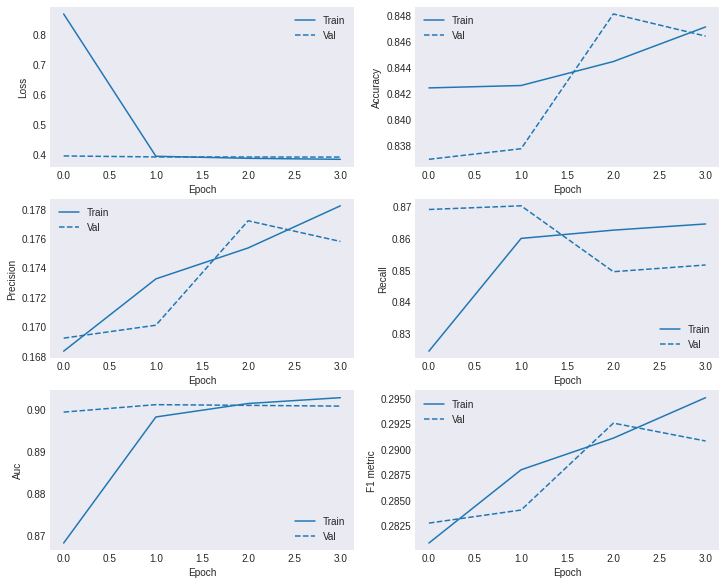

In [33]:
plot_metrics(historymh)

In [34]:
model.save('../../ml/model/attention_model/model.h5')

# Test set loading

In [1]:
#cells to execute
from IPython.display import Javascript
Javascript("Jupyter.notebook.execute_cells([0])")

<IPython.core.display.Javascript object>

In [3]:
Javascript("Jupyter.notebook.execute_cells([2])")

<IPython.core.display.Javascript object>

In [5]:
Javascript("Jupyter.notebook.execute_cells([4])")

<IPython.core.display.Javascript object>

In [7]:
Javascript("Jupyter.notebook.execute_cells([28])")

<IPython.core.display.Javascript object>

In [8]:
Javascript("Jupyter.notebook.execute_cells([29])")

<IPython.core.display.Javascript object>

In [10]:
Javascript("Jupyter.notebook.execute_cells([30])")

<IPython.core.display.Javascript object>

In [19]:
Javascript("Jupyter.notebook.execute_cells([33])")

<IPython.core.display.Javascript object>

In [15]:
config['data']['dataset_filename']

'../../ml/input/data/raw/crm_tests_user_tracking.csv'

In [14]:
# config['data']['dataset_filename'] = '../../ml/input/data/raw/M_A_dataset_twoweek_crm.csv'
# config['data']['dataset_filename'] = '../../ml/input/data/raw/M_A_dataset_twoweek_fb.csv'
config['data']['dataset_filename'] = '../../ml/input/data/raw/crm_tests_user_tracking.csv'

In [16]:
#previous parameters - from training
#load funcions and load tensorflow custom layers

# maxlen= 8
Ccols=['birthday',
 'cust_created_year',
 'country_region_(not set)',
 'country_region_federal district',
 'country_region_foreign_country',
 'country_region_state of acre',
 'country_region_state of alagoas',
 'country_region_state of amapa',
 'country_region_state of amazonas',
 'country_region_state of bahia',
 'country_region_state of ceara',
 'country_region_state of espirito santo',
 'country_region_state of goias',
 'country_region_state of maranhao',
 'country_region_state of mato grosso',
 'country_region_state of mato grosso do sul',
 'country_region_state of minas gerais',
 'country_region_state of para',
 'country_region_state of paraiba',
 'country_region_state of parana',
 'country_region_state of pernambuco',
 'country_region_state of piaui',
 'country_region_state of rio de janeiro',
 'country_region_state of rio grande do norte',
 'country_region_state of rio grande do sul',
 'country_region_state of rondonia',
 'country_region_state of roraima',
 'country_region_state of santa catarina',
 'country_region_state of sao paulo',
 'country_region_state of sergipe',
 'country_region_state of tocantins',
 'gender_female',
 'gender_male',
'gender_not_set']

## Predict in chunks

In [21]:
#loading test dataset
print(f'Initial memory footprint: {memory_footprint()} in MB')
# config['data']['dataset_filename']='../../ml/input/data/raw/M_A_dataset_twoweek_fb.csv'
#tokenizer loading
with open('../../ml/model/attention_model/tokenizer.pickle', 'rb') as handle:
    tk = pickle.load(handle)
#model loading
model=tf.keras.models.load_model(
    '../../ml/model/attention_model/model.h5',
    custom_objects={
        'TokenAndPositionEmbedding': TokenAndPositionEmbedding,
        'MultiHeadSelfAttention': MultiHeadSelfAttention,
        'f1_metric':f1_metric
    }
)
inlist=[(l.name, '*', l.input_shape, '*', l.dtype) for l in model.layers]
maxlen = inlist[0][2][0][1]
print(f'MAXLEN: {maxlen}')
model.summary()
print(f'After model memory footprint: {memory_footprint()} in MB')

Initial memory footprint: 465.19140625 in MB
MAXLEN: 8
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_path (InputLayer)         [(None, 8)]          0                                            
__________________________________________________________________________________________________
input_timedecay (InputLayer)    [(None, 8)]          0                                            
__________________________________________________________________________________________________
token_and_position_embedding (T (None, 8, 64)        320512      input_path[0][0]                 
                                                                 input_timedecay[0][0]            
__________________________________________________________________________________________________
multi_head_self_attention (Mult ((None,

In [22]:
memory_footprint()

529.63671875

In [23]:
config['data']['maximum_memory_usage']=3000

In [25]:
def load_and_predict_test_dataframe(config=config,maxlen=maxlen,Ccols=Ccols,tk=tk,model=model):
    t0=time()
    flatten = lambda l: [item for sublist in l for item in sublist]
    filename = config['data']['dataset_filename']
    chunksize = config['data']['csv_parsing_chunksize']
    drop_aggsessions = config['data']['drop_aggsessions_from_dataframe']
    test_one_chunk=config['data']['test_one_chunk']
    maximum_memory_usage=config['data']['maximum_memory_usage']
    #set attention model
    attention_layer = model.layers[3] # or model.get_layer("attention”)
    attention_model = Model(inputs=model.inputs, outputs=model.outputs + [attention_layer.output])
    print('Calculating chunks...')
# '''Returns memory (in MB) being used by Python process'''
    with open(filename, 'r') as f:
        total_lines = sum(1 for line in f) - 1
    num_chunks = int(np.ceil(total_lines/chunksize))
    print(f'Dataset name: {filename}')
    print(f'Chunck size: {chunksize}.\nTotal number of chunks: {num_chunks}')
    print('\nImporting dataset...')
    df_iterator = pd.read_csv(filename, chunksize=chunksize)
    corpus = []
    y_true = []
    y_pred = []
    W = []
    df_s = pd.DataFrame()
    df_tri= pd.DataFrame()
    df_tripos= pd.DataFrame()
    df_utm= pd.DataFrame()
    df_utmpos= pd.DataFrame()
    df_con = pd.DataFrame()
    df_gid = pd.DataFrame()
    for df_c in tqdm(df_iterator, total=num_chunks):
#CONTROL VARIABLES BY CLIENT
#creating conversion groups based on num_orders
        df_c['agg_sessions']=df_c['agg_sessions'].str.split(';')
        df_c=df_c.explode('agg_sessions')
        df_c['agg_sessions']=df_c['agg_sessions'].str.split(':')
        # get parameters from agg_sessions
# creating columns spliting session informations
#         CROP ONLY FULLVISITOR ID IDENTIFICATOR
        df_c=df_c[df_c['gid'].apply(str).str.contains(':')==False]
        df_c['utm_hash']=df_c['agg_sessions'].apply(lambda x: x[0]).str.split(',')
        df_c['sess']=df_c['agg_sessions'].apply(lambda x: np.fromstring(x[1],dtype=int,sep=(','))).apply(lambda x: time_decay(x))
        df_c['trinomials']=df_c['agg_sessions'].apply(lambda x: x[2]).str.replace(' ','').str.replace('1','kwDft').str.replace('0','nokwDft').str.split(',')
        df_c['value']=df_c['agg_sessions'].apply(lambda x: np.fromstring(x[3],dtype=float,sep=(',')))
        df_c=df_c[df_c['utm_hash'].apply(len)<=maxlen]

        df_c_con=(df_c[['gid','country_region','gender','birthday','cust_created_year']])
        df_c_gid=df_c[['gid','os','is_control','fk_customer','country']]
        df_c=df_c.drop(['agg_cvg'
#                         ,'agg_sessions'
                       ],axis=1)
        df_c=df_c.drop(['gid','os','is_control','fk_customer','country','country_region','gender','birthday','cust_created_year'],axis=1)
        df_s=df_s.append(df_c)
        df_con=df_con.append(df_c_con)
        df_gid=df_gid.append(df_c_gid)

        y_test=(df_c['value']>0).values.astype(int)
        y_true.append(list(y_test))
#NLP processing         
        corpus_test=df_c['utm_hash'].to_list()
        X_test=tk.texts_to_sequences(corpus_test)
        X_test = pad_sequences(X_test, maxlen=maxlen,padding='post') # customer path
        TD_test=pad_sequences(df_c['sess'].values,maxlen=maxlen,dtype='float32',padding='post') # time decay from sessions
        C_test=pd.DataFrame(columns=Ccols) #to C_test to have same dimensions of C_train
        C=pd.get_dummies(df_c_con.drop('gid',axis=1), columns=['country_region', 'gender'])# customer dependet 
        C_test=C_test.append(C)
        C_test=C_test.fillna(0)
# attention_model
        y_pred0, _,W0 = attention_model.predict([X_test,TD_test,C_test], batch_size=config['attention']['BATCH_SIZE']) #out,att,W=...
        W.append(W0)
        y_pred.append(list(y_pred0))
        if test_one_chunk:
            print('One Chunk ok!')
            break
        if memory_footprint()>maximum_memory_usage:
            print('memory footprint')
            print('Process broken by memory..')
            print(f'Memory used by python process is  {np.round(memory_footprint(),2)} MB')
            print(f'Is greater than the maximum memory usage parameter: {maximum_memory_usage} MB')
            print(f'Final Dataframe shape {df_s.shape}')
            print(f'Done! {np.round((time()-t0)/60,2)} min spent')
            break
            
    y_pred=np.array(flatten(y_pred))
    y_true=np.array(flatten(y_true))
    W=np.array(flatten(W))
    W=(W.sum(axis=1))/2 #sum over heads [dim_corpus, dim_heads, dim_maxlen, dim_maxlen] 

    return y_true, y_pred, df_con,df_s,W,df_gid#, df_tri,df_tripos,df_utm,df_utmpos

In [26]:
y_true, y_pred, df_con, df_s, W, df_gid = load_and_predict_test_dataframe(config=config,maxlen=maxlen,Ccols=Ccols,tk=tk,model=model)

  0%|          | 0/2 [00:00<?, ?it/s]

Calculating chunks...
Dataset name: ../../ml/input/data/raw/crm_tests_user_tracking.csv
Chunck size: 100000.
Total number of chunks: 2

Importing dataset...


100%|██████████| 2/2 [00:19<00:00,  9.53s/it]


In [34]:
df_s['y_true']=y_true
df_aux=(df_s.explode('trinomials').groupby('y_true')['trinomials'].value_counts()).unstack().T.fillna(0)#to_frame().sum(axis=1)
df_aux.div(df_aux.sum()).sort_values(by=0,ascending=False)

y_true,0,1
trinomials,,
prospecting_dp_nokwDft,0.249852,0.231240
pushnotification_crm_nokwDft,0.176841,0.137248
(direct)_(none)_nokwDft,0.135448,0.126124
google_cpc_nokwDft,0.104789,0.118165
emailtrans_dafiti_em_nokwDft,0.080899,0.035358
...,...,...
qo-br.com_referral_nokwDft,0.000000,0.000034
ciadosdescontos_(notset)_nokwDft,0.000000,0.000007
t-qpfgzkwDftep_xxtrtlij8kbawuunys_nokwDft_(notset)_nokwDft,0.000000,0.000007


In [35]:
df_gid = df_gid.reset_index(drop=True)
df_s = df_s.reset_index(drop=True)
df_con = df_con.reset_index(drop=True)

In [108]:
# df_gid

In [39]:
print(df_s['utm_hash'].iloc[34])
print('*')
print(df_s['agg_sessions'].apply(lambda x: x[0]).str.split(',').iloc[34])

['2ee90d1c15514cc3888ba0a2a56cc3f6', '2ee90d1c15514cc3888ba0a2a56cc3f6', '2ee90d1c15514cc3888ba0a2a56cc3f6']
*
['2ee90d1c15514cc3888ba0a2a56cc3f6', '2ee90d1c15514cc3888ba0a2a56cc3f6', '2ee90d1c15514cc3888ba0a2a56cc3f6']


In [40]:
df_exp=df_s[['utm_hash', 'trinomials']]
exp_trinomials=df_exp['trinomials'].explode()
df_exp=df_exp.explode('utm_hash')
df_exp['exp_trinomials']=exp_trinomials
del exp_trinomials
tri2hash=df_exp.groupby(['exp_trinomials'])['utm_hash'].apply(list).apply(set).apply(list)#.to_dict()
hash2tri = tri2hash.to_frame().reset_index().explode('utm_hash').set_index('utm_hash')
hash2tri=hash2tri.reset_index().drop_duplicates(subset='utm_hash').set_index('utm_hash')

In [42]:
all_medium=list(set(flatten(df_s['utm_hash'].tolist())))
attention_layer = model.layers[3] # or model.get_layer("attention”)
attention_model = Model(inputs=model.inputs, outputs=model.outputs + [attention_layer.output])

In [45]:
tk_medium = list(tk.word_index.items())[:tk.num_words]
important_medium = list(dict(tk_medium).keys())

In [46]:
all_important_medium = [elt for elt in all_medium if elt in important_medium]
len(all_important_medium)

3718

In [49]:
minimum_occurrences = 15
important_df_utm = df_s['utm_hash'].explode().value_counts()[df_s['utm_hash'].explode().value_counts()>minimum_occurrences].index.tolist()
len(important_df_utm)

1514

In [50]:
all_df_important_medium = [elt for elt in all_important_medium if elt in important_df_utm]
print(len(all_df_important_medium))

1162


## Removal Effect

### split by os and is_control

In [52]:
is_true_remove=False

In [53]:
ls=[]
is_control_list=np.zeros(len(all_medium)).astype(int).tolist() + np.ones(len(all_medium)).astype(int).tolist()
utm_hash_duplicated_list=all_medium + all_medium
os_list=(
    (((df_gid.os.unique()).tolist()*len(all_medium))[0:][::2])
    +(((df_gid.os.unique()).tolist()*len(all_medium))[1:][::2])
)
is_control_list= is_control_list+ is_control_list[::-1]
utm_hash_duplicated_list = utm_hash_duplicated_list + utm_hash_duplicated_list
os_list = os_list + os_list
ls.append(utm_hash_duplicated_list)
ls.append(is_control_list)
ls.append(os_list)
index = pd.MultiIndex.from_tuples(list(zip(*ls)), names=['utm_hash', 'is_control','os'])
rm_effect=pd.DataFrame(index=index,columns={'s_i','s_rm','rm_eff','n_occ','trinomials'}).reset_index()
test=['734a5301ef3dfdf22cdfe7187aeb9430']
for is_control in reversed(range(2)):
    print('Is control group?: ', is_control)
    is_control_index=df_gid[(df_gid['is_control']==is_control)].index.to_list()
    for os in df_gid.os.unique():
        print('OS: ', os)
        os_index=df_gid[(df_gid['os']==os)].index.to_list()
#         for mtest in tqdm(test):
        for mtest in tqdm(all_df_important_medium):
    #         rm_effect.loc[(mtest,is_control)]['trinomials']=hash2tri.loc[mtest]['exp_trinomials']
            idx_m_isc_os=rm_effect[(rm_effect['os']==os) & (rm_effect['is_control']==is_control) & (rm_effect['utm_hash']==mtest)].index
            rm_effect.loc[idx_m_isc_os,'trinomials']=hash2tri.loc[mtest]['exp_trinomials']
            #######
            df_s['rm'] = (
                df_s[
                    (df_s.index.isin(is_control_index)) & 
                    (df_s.index.isin(os_index)) &
                    (df_s['utm_hash'].apply(lambda x: x.count(mtest))>0)
                ]
                ['utm_hash']
                .apply(lambda x: list(duplicates(x,mtest))[::-1])
            )
            dft=df_s.query('rm.notnull().values')
#             dftc=df_con.loc[is_control_index].loc[df_s.query('rm.notnull().values').index]
            dftc=df_con.loc[df_s.query('rm.notnull().values').index]
            df_s=df_s.drop(columns='rm',axis=1)
            corpus_test=dft['utm_hash'].to_list()
            X_test=tk.texts_to_sequences(corpus_test)
            X_test = pad_sequences(X_test, maxlen=maxlen,padding='post') # customer path
            TD_test=pad_sequences(dft['sess'].values,maxlen=maxlen,dtype='float32',padding='post') # time decay from sessions
            C=pd.get_dummies(dftc.drop('gid',axis=1), columns=['country_region', 'gender']).values
            C_test=pd.DataFrame(columns=Ccols) #to C_test to have same dimensions of C_train
            C_test = C_test.append(pd.get_dummies(dftc.drop('gid',axis=1), columns=['country_region', 'gender']))
            C_test = C_test.fillna(0).values
            if C_test.shape[0]>0:
                y_pred_i, _,_ = attention_model.predict([X_test,TD_test,C_test], batch_size=config['attention']['BATCH_SIZE']) #out,att,W=...
                y_true0 = (dft['value']>0).values.astype(int)
                to_rm=dft['rm'].values
                if is_true_remove:
                    for ii in range(X_test.shape[0]):
                        X_test[ii][to_rm[ii]]=0
                        TD_test[ii][to_rm[ii]]=0
                    mask = X_test.sum(axis=1)!=0
                    y_pred_i = y_pred_i[mask]
                    y_true0 = y_true0[mask]
                    X_test = X_test[mask]
                    TD_test = TD_test[mask]
                    C_test = C_test[mask,:]
                else:
    #                 token=tk.word_index[mtest]
                    try: token=tk.word_index[mtest]
                    except: 
                        utm_hash_without_token.append(mtest)
                        token = 0
                    if token >tk.num_words: token=0
                    token_list = np.arange(0,token).tolist() + np.arange(token+1,tk.num_words).tolist()
                    for ii in range(X_test.shape[0]):
                        X_test[ii][to_rm[ii]]=np.random.choice(token_list,len(to_rm[ii]))
                if C_test.shape[0]>0:
                    y_pred_rm, _,W0 = attention_model.predict([X_test,TD_test,C_test], batch_size=config['attention']['BATCH_SIZE']) #out,att,W=...
                    rm_effect.loc[idx_m_isc_os,'n_occ']=y_true0.shape[0]
                    if any(y_true0==1):
                        s_i = np.sum(y_pred_i[y_true0==1])
                        s_rm = np.sum(y_pred_rm[y_true0==1])
                        rm_val = ((np.median(y_pred_rm[y_true0==1])
                                   -np.median(y_pred_i[y_true0==1]))
                                  / np.median(y_pred_i[y_true0==1])
                                 )
                        if np.isnan(rm_val)==False:
                            rm_effect.loc[idx_m_isc_os,'s_i']=s_i
                            rm_effect.loc[idx_m_isc_os,'s_rm']=s_rm
                            rm_effect.loc[idx_m_isc_os,'rm_eff']=rm_val
rm_effect['scaled_rm_eff'] = rm_effect['n_occ']*rm_effect['rm_eff']

  0%|          | 0/1162 [00:00<?, ?it/s]

Is control group?:  1
OS:  AND


  0%|          | 0/1162 [00:00<?, ?it/s]

OS:  IOS


  0%|          | 0/1162 [00:00<?, ?it/s]

Is control group?:  0
OS:  AND


  0%|          | 0/1162 [00:00<?, ?it/s]

OS:  IOS


100%|██████████| 1162/1162 [08:56<00:00,  2.17it/s]


In [59]:
rm_effect#.to_csv('../../ml/model/attention_model/rm_effect_crm_trained_on_twoweekCRM.csv')
# config['data']['dataset_filename']
# import os
# os.listdir('../../ml/model/attention_model/')

,utm_hash,is_control,os,s_i,s_rm,trinomials,rm_eff,n_occ,scaled_rm_eff
0,d91a231a6cd5db180172858ae63f456f,0,AND,NaN,NaN,NaN,NaN,NaN,NaN
1,e56711b4c6f48b63059dda5213465b68,0,AND,NaN,NaN,NaN,NaN,NaN,NaN
2,551d1d67d9d9764c3662ea47c40ad6ae,0,AND,NaN,NaN,NaN,NaN,NaN,NaN
3,652768f508f95419342773224944a6b7,0,AND,NaN,NaN,NaN,NaN,NaN,NaN
4,4c3af6fc0f474034a282c6e353f82c44,0,AND,NaN,NaN,google_cpc_kwDft,NaN,3,NaN
...,...,...,...,...,...,...,...,...,...
66131,24ab19699574b6394578464a38eb3143,0,IOS,NaN,NaN,NaN,NaN,NaN,NaN
66132,f23f7aa3f5b0a968e414500ee73c05f9,0,IOS,NaN,NaN,NaN,NaN,NaN,NaN
66133,28ce1a74c8ca1dd83f61997789e3820a,0,IOS,0.86277,0.932482,pushnotification_crm_nokwDft,0.0807993,9,0.727193
66134,449287b830d73708b1b760de8df79adf,0,IOS,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
rm_effect[rm_effect['utm_hash']==mtest]

,utm_hash,is_control,os,s_rm,trinomials,s_i,rm_eff,n_occ,scaled_rm_eff
15007,a8bdd4126c5fad1c1f457679b260c75d,0,AND,1.76418,google_cpc_kwDft,1.81268,-0.0267579,4,-0.107032
30030,a8bdd4126c5fad1c1f457679b260c75d,1,IOS,3.91704,google_cpc_kwDft,3.94647,-0.00326243,5,-0.0163122
45053,a8bdd4126c5fad1c1f457679b260c75d,1,AND,2.6596,google_cpc_kwDft,2.76671,-0.0194484,8,-0.155587
60076,a8bdd4126c5fad1c1f457679b260c75d,0,IOS,5.87904,google_cpc_kwDft,6.51166,-0.026131,16,-0.418095


In [334]:
rm_effect.query('rm_eff.notna().values')[['utm_hash','trinomials','n_occ','rm_eff']]#.sort_values(by='rm_eff')

,utm_hash,trinomials,n_occ,rm_eff
69,c9a5b812f742cbdaab4073f8d1e6594f,google_cpc_nokwDft,25,-0.282574
72,df4db6022b45bbd44530cc94dc400af8,emailpromo_dafiti_em_nokwDft,7,0.00467088
73,2f6338be41ac6531865c78b283fee3dc,emailtrans_dafiti_em_nokwDft,4,-0.0399063
79,56b16f542acec886318ead58099e969a,pushnotification_crm_nokwDft,15,-0.452138
190,5dbbf7284bc3af2ef447ce74e8abcd9b,pushnotification_crm_nokwDft,32,-0.0189713
...,...,...,...,...
65988,c3b7bfd2a00296c50ddb9dd834bf0099,google_cpc_nokwDft,13,-0.11354
66003,f96a29bf661aadf1509f0dd724c02712,emailtrans_dafiti_em_nokwDft,38,1.41919
66007,e83dd71813fa3334d6df15d4f85fe4a7,pushnotification_crm_nokwDft,51,-0.0618825
66048,601a0115668ff811403502f52f58f6b3,prospecting_dp_nokwDft,12,-0.622152


In [66]:
df_tri_re = (rm_effect#.loc[tri2hash.to_dict()['google_cpc_nokwDft']]
     .query('rm_eff.notna().values')
     .query('n_occ>25')
     .groupby(['trinomials','os','is_control'])
     .agg({'n_occ':{'sum','count'},'rm_eff':'sum','scaled_rm_eff':'sum'})
)
df_tri_re['m_rm_eff']=df_tri_re['rm_eff']['sum']/df_tri_re['n_occ']['count']
df_tri_re#.reset_index().to_csv('teste.csv')#.loc['google_cpc_nokwDft']

n_occ          rm_eff  \
                                                     sum count       sum   
trinomials                         os  is_control                          
(direct)_(none)_kwDft              AND 0           18270     1 -0.168032   
                                       1            6539     1 -0.164710   
                                   IOS 0           12587     1 -0.155141   
                                       1            1856     1 -0.163382   
bing_cpc_kwDft                     AND 0              94     1 -0.091422   
...                                                  ...   ...       ...   
pushnotification_em_nokwDft        AND 1              34     1 -0.113788   
radarcupom.com.br_referral_nokwDft IOS 0              27     1 -0.126576   
rakuten_af_nokwDft                 AND 0              80     2  0.014420   
                                   IOS 0             168     2 -0.038376   
tecmundo.com.br_referral_nokwDft   IOS 0              48     1 -0.116725   

                                                  scaled_rm_eff  m_rm_eff  
                                                            sum            
trinomials                         os  is_control                          
(direct)_(none)_kwDft              AND 0           -3069.953451 -0.168032  
                                       1           -1077.038983 -0.164710  
                                   IOS 0           -1952.765156 -0.155141  
                                       1            -303.237672 -0.163382  
bing_cpc_kwDft                     AND 0              -8.593706 -0.091422  
...                                                         ...       ...  
pushnotification_em_nokwDft        AND 1              -3.868785 -0.113788  
radarcupom.com.br_referral_nokwDft IOS 0              -3.417556 -0.126576  
rakuten_af_nokwDft                 AND 0               0.719495  0.007210  
                                   IOS 0              -2.194683 -0.019188  
tecmundo.com.br_referral_nokwDft   IOS 0              -5.602823 -0.116725  

[77 rows x 5 columns]

In [68]:
rm_effect

,utm_hash,is_control,os,s_i,s_rm,trinomials,rm_eff,n_occ,scaled_rm_eff
0,d91a231a6cd5db180172858ae63f456f,0,AND,NaN,NaN,NaN,NaN,NaN,NaN
1,e56711b4c6f48b63059dda5213465b68,0,AND,NaN,NaN,NaN,NaN,NaN,NaN
2,551d1d67d9d9764c3662ea47c40ad6ae,0,AND,NaN,NaN,NaN,NaN,NaN,NaN
3,652768f508f95419342773224944a6b7,0,AND,NaN,NaN,NaN,NaN,NaN,NaN
4,4c3af6fc0f474034a282c6e353f82c44,0,AND,NaN,NaN,google_cpc_kwDft,NaN,3,NaN
...,...,...,...,...,...,...,...,...,...
66131,24ab19699574b6394578464a38eb3143,0,IOS,NaN,NaN,NaN,NaN,NaN,NaN
66132,f23f7aa3f5b0a968e414500ee73c05f9,0,IOS,NaN,NaN,NaN,NaN,NaN,NaN
66133,28ce1a74c8ca1dd83f61997789e3820a,0,IOS,0.86277,0.932482,pushnotification_crm_nokwDft,0.0807993,9,0.727193
66134,449287b830d73708b1b760de8df79adf,0,IOS,NaN,NaN,NaN,NaN,NaN,NaN


In [335]:
df_tri_re.tail(30)#['m_rm_eff'].plot(kind='barh',figsize=(15,9))#.sort_values(by='mean_rm_eff')

n_occ         \
                                                          count    sum   
trinomials                                 os  is_control                
google_search_nokwDft                      IOS 0              1    111   
kwDft29424kwDft759_af_nokwDft              AND 0              6    315   
                                               1              3     97   
                                           IOS 0              4    467   
kwDft29424kwDft984_fb_nokwDft              AND 0              2    172   
                                               1              1     31   
                                           IOS 0              1    176   
kwDft3nokwDftnokwDft32_pa_nokwDft          IOS 0              1     35   
livelo_af_nokwDft                          IOS 1              1     51   
maodevacadescontos.com.br_referral_nokwDft IOS 0              1     59   
paraisofeminino_fd_nokwDft                 AND 0              1     47   
                                           IOS 0              1     49   
prospecting_dp_nokwDft                     AND 0             15  28238   
                                               1             13  10928   
                                           IOS 0             10   4240   
                                               1              4    521   
pushcf_crm_nokwDft                         AND 0              1     28   
pushcf_em_nokwDft                          AND 0              4   1950   
                                               1              2    210   
                                           IOS 0              2    205   
pushnotification_crm_nokwDft               AND 0            180  28041   
                                               1             58   4602   
                                           IOS 0             29   1378   
                                               1              1     29   
pushnotification_em_nokwDft                AND 0              2     55   
                                               1              1     34   
radarcupom.com.br_referral_nokwDft         IOS 0              1     27   
rakuten_af_nokwDft                         AND 0              2     80   
                                           IOS 0              2    168   
tecmundo.com.br_referral_nokwDft           IOS 0              1     48   

                                                              rm_eff  m_rm_eff  
                                                                 sum            
trinomials                                 os  is_control                       
google_search_nokwDft                      IOS 0           -0.324342 -0.324342  
kwDft29424kwDft759_af_nokwDft              AND 0            3.597297  0.599549  
                                               1           -0.089114 -0.029705  
                                           IOS 0           -0.917450 -0.229362  
kwDft29424kwDft984_fb_nokwDft              AND 0           -0.132253 -0.066126  
                                               1            0.007563  0.007563  
                                           IOS 0           -0.147775 -0.147775  
kwDft3nokwDftnokwDft32_pa_nokwDft          IOS 0           -0.204295 -0.204295  
livelo_af_nokwDft                          IOS 1            0.008052  0.008052  
maodevacadescontos.com.br_referral_nokwDft IOS 0           -0.008556 -0.008556  
paraisofeminino_fd_nokwDft                 AND 0           -0.186682 -0.186682  
                                           IOS 0           -0.337080 -0.337080  
prospecting_dp_nokwDft                     AND 0           -4.810111 -0.320674  
                                               1           -3.937678 -0.302898  
                                           IOS 0           -2.030427 -0.203043  
                                               1           -1.089841 -0.272460  
pushcf_crm_nokwDft                         AND 0           -0.385301 -0.3853

In [341]:
df_tri_re[df_tri_re['n_occ']['sum']>50]

n_occ         \
                                                          count    sum   
trinomials                                 os  is_control                
(direct)_(none)_kwDft                      AND 0              1  18270   
                                               1              1   6539   
                                           IOS 0              1  12587   
                                               1              1   1856   
bing_cpc_kwDft                             AND 0              1     94   
                                           IOS 0              1    240   
cupomvalido_af_nokwDft                     IOS 0              1     68   
cuponation_(notset)_nokwDft                AND 0              1    122   
                                           IOS 0              1    606   
                                               1              1     72   
emailcf_em_nokwDft                         AND 0              1     55   
                                           IOS 0              1    125   
emailpromo_dafiti_em_nokwDft               AND 0              2     87   
                                           IOS 0             12    554   
emailtrans_dafiti_em_nokwDft               AND 0             52   3619   
                                               1             19    725   
                                           IOS 0             71   9183   
                                               1             12    423   
facebook_app_nokwDft                       AND 0              1   2386   
                                               1              1    793   
                                           IOS 0              1     57   
facebook_dp_nokwDft                        AND 0             11    637   
                                               1              3    221   
                                           IOS 0             16    983   
google_cpc_kwDft                           AND 0             14   5524   
                                               1             13   2007   
                                           IOS 0             19   7575   
                                               1             10    995   
google_cpc_nokwDft                         AND 0             79   7938   
                                               1             33   1996   
                                           IOS 0             58   3931   
                                               1              4    147   
google_organic_nokwDft                     AND 0              2   2154   
                                               1              2    646   
                                           IOS 0              1   4621   
                                               1              1    612   
google_search_nokwDft                      AND 0              1    726   
                                               1              1    260   
                                           IOS 0              1    111   
kwDft29424kwDft759_af_nokwDft              AND 0              6    315   
                                               1              3     97   
                                           IOS 0              4    467   
kwDft29424kwDft984_fb_nokwDft              AND 0              2    172   
                                           IOS 0              1    176   
livelo_af_nokwDft                          IOS 1              1     51   
maodevacadescontos.com.br_referral_nokwDft IOS 0              1     59   
prospecting_dp_nokwDft                     AND 0             15  28238   
                                               1             13  10928   
                                           IOS 0             10   4240   
                                               1              4    521   
pushcf_em_nokwDft                          AND 0              4   1950   
                                               1              

In [85]:
trinomials=list(set([elt[0] for elt in df_tri_re.index]))
compare_tri = [tri for tri in trinomials if df_tri_re.loc[tri].shape[0]>3]
compare_tri
cols = [col for col in df_tri_re.columns if col not in ['n_occ']]

In [87]:
ls=[]
is_control_list=np.zeros(len(compare_tri)).astype(int).tolist() + np.ones(len(compare_tri)).astype(int).tolist()
tri_list=compare_tri + compare_tri
os_list=(
    (((df_gid.os.unique()).tolist()*len(compare_tri))[0:][::2])
    +(((df_gid.os.unique()).tolist()*len(compare_tri))[1:][::2])
)
is_control_list= is_control_list+ is_control_list[::-1]
tri_list = tri_list + tri_list
os_list = os_list + os_list
ls.append(tri_list)
ls.append(os_list)
# ls.append(is_control_list)
index = pd.MultiIndex.from_tuples(list(zip(*ls)), names=['utm_hash','os'])
df_compare=pd.DataFrame(index=index,columns=cols)#.reset_index()
# df_compare

In [88]:
for tri in compare_tri:
    for os in (df_gid.os.unique()).tolist():
        f_scale = df_tri_re.loc[tri].loc[os]['n_occ'][0]/df_tri_re.loc[tri].loc[os]['n_occ'][1]
        for col in cols:
            df_compare.loc[(tri,os,)]=((df_tri_re.loc[tri].loc[os][col][0]-(df_tri_re.loc[tri].loc[os][col][1]*f_scale))
                                     /(df_tri_re.loc[tri].loc[os][col][0]+(df_tri_re.loc[tri].loc[os][col][1]*f_scale))
                                    )
df_compare#.loc[(compare_tri[0],'AND',0)]#['n_occ']

/home/renan.romano/miniconda3/envs/teste/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


,,rm_eff,scaled_rm_eff,mean_rm_eff
utm_hash,os,,,
facebook_dp_nokwDft,AND,-1.38502,-1.38502,-1.38502
cuponation_(notset)_nokwDft,AND,-0.924457,-0.924457,-0.924457
pushnotification_crm_nokwDft,AND,-0.642728,-0.642728,-0.642728
google_cpc_nokwDft,AND,0.662526,0.662526,0.662526
google_cpc_kwDft,AND,-0.734688,-0.734688,-0.734688
google_organic_nokwDft,AND,-0.732998,-0.732998,-0.732998
prospecting_dp_nokwDft,AND,-0.650875,-0.650875,-0.650875
emailtrans_dafiti_em_nokwDft,AND,-1.11421,-1.11421,-1.11421
(direct)_(none)_kwDft,AND,-0.765847,-0.765847,-0.765847


### Split only in control group

In [40]:
is_true_remove=False

In [40]:
ls=[]
utm_hash_without_token=[]
is_control_list=np.zeros(len(all_medium)).astype(int).tolist() + np.ones(len(all_medium)).astype(int).tolist()
utm_hash_duplicated_list=all_medium + all_medium
ls.append(utm_hash_duplicated_list)
ls.append(is_control_list)
index = pd.MultiIndex.from_tuples(list(zip(*ls)), names=['utm_hash', 'is_control'])
rm_effect=pd.DataFrame(index=index,columns={'rm_eff','n_occ','trinomials'}).reset_index()
test=['734a5301ef3dfdf22cdfe7187aeb9430']
for is_control in reversed(range(2)):
    is_control_index=df_gid[(df_gid['is_control']==is_control)].index.to_list()
#     for mtest in tqdm(test):
    for mtest in tqdm(all_important_medium):
#         rm_effect.loc[(mtest,is_control)]['trinomials']=hash2tri.loc[mtest]['exp_trinomials']
        idx_m_isc=rm_effect[(rm_effect['is_control']==is_control) & (rm_effect['utm_hash']==mtest)].index
        rm_effect.loc[idx_m_isc,'trinomials']=hash2tri.loc[mtest]['exp_trinomials']
        #######
        df_s['rm'] = (
            df_s[
                (df_s.index.isin(is_control_index)) & 
                (df_s['utm_hash'].apply(lambda x: x.count(mtest))>0)
            ]
            ['utm_hash']
            .apply(lambda x: list(duplicates(x,mtest))[::-1])
        )
        dft=df_s.query('rm.notnull().values')
        dftc=df_con.loc[is_control_index].loc[df_s.query('rm.notnull().values').index]
        df_s=df_s.drop(columns='rm',axis=1)
        corpus_test=dft['utm_hash'].to_list()
        X_test=tk.texts_to_sequences(corpus_test)
        X_test = pad_sequences(X_test, maxlen=maxlen,padding='post') # customer path
        TD_test=pad_sequences(dft['sess'].values,maxlen=maxlen,dtype='float32',padding='post') # time decay from sessions
        C=pd.get_dummies(dftc.drop('gid',axis=1), columns=['country_region', 'gender']).values
        C_test=pd.DataFrame(columns=Ccols) #to C_test to have same dimensions of C_train
        C_test = C_test.append(pd.get_dummies(dftc.drop('gid',axis=1), columns=['country_region', 'gender']))
        C_test = C_test.fillna(0).values
        if C_test.shape[0]>0:
            y_pred_i, _,_ = attention_model.predict([X_test,TD_test,C_test], batch_size=config['attention']['BATCH_SIZE']) #out,att,W=...
            y_true0 = (dft['value']>0).values.astype(int)
            to_rm=dft['rm'].values
            if is_true_remove:
                for ii in range(X_test.shape[0]):
                    X_test[ii][to_rm[ii]]=0
                    TD_test[ii][to_rm[ii]]=0
                mask = X_test.sum(axis=1)!=0
                y_pred_i = y_pred_i[mask]
                y_true0 = y_true0[mask]
                X_test = X_test[mask]
                TD_test = TD_test[mask]
                C_test = C_test[mask,:]
            else:
#                 token=tk.word_index[mtest]
                try: token=tk.word_index[mtest]
                except: 
                    utm_hash_without_token.append(mtest)
                    token = 0
                if token >tk.num_words: token=0
                token_list = np.arange(0,token).tolist() + np.arange(token+1,tk.num_words).tolist()
                for ii in range(X_test.shape[0]):
                    X_test[ii][to_rm[ii]]=np.random.choice(token_list,len(to_rm[ii]))
            if C_test.shape[0]>0:
                y_pred_rm, _,W0 = attention_model.predict([X_test,TD_test,C_test], batch_size=config['attention']['BATCH_SIZE']) #out,att,W=...
                rm_effect.loc[idx_m_isc,'n_occ']=y_true0.shape[0]
                if any(y_true0==1):
                    rm_val = ((np.median(y_pred_rm[y_true0==1])
                               -np.median(y_pred_i[y_true0==1]))
                              / np.median(y_pred_i[y_true0==1])
                             )
                    if np.isnan(rm_val)==False:
                        rm_effect.loc[idx_m_isc,'rm_eff']=rm_val
rm_effect['scaled_rm_eff'] = rm_effect['n_occ']*rm_effect['rm_eff']

100%|██████████| 3522/3522 [25:46<00:00,  2.28it/s]  


In [44]:
rm_effect.query('n_occ.notna().values').sort_values(by='n_occ',ascending=False).head(10)

,utm_hash,is_control,n_occ,rm_eff,trinomials,scaled_rm_eff
8849,42b4c899c39ac03cc595b36e8a618951,0,32869,-0.252398,(direct)_(none)_kwDft,-8296.08
7874,4f5445efbd48f8c8405addb9e3e6818e,0,19363,-0.315076,prospecting_dp_nokwDft,-6100.81
22495,42b4c899c39ac03cc595b36e8a618951,1,10723,-0.275495,(direct)_(none)_kwDft,-2954.13
4780,9f3d23b2254910561e1778450e4b3d13,0,8402,-0.0751574,google_organic_nokwDft,-631.472
21520,4f5445efbd48f8c8405addb9e3e6818e,1,6351,-0.357567,prospecting_dp_nokwDft,-2270.91
8740,0adaf157fa87c264cd6a5ef5e718e34c,0,4111,-0.112744,google_cpc_kwDft,-463.49
11416,68284d2fe147e66017e61b51063c9b7f,0,3613,-0.166148,google_cpc_kwDft,-600.293
2303,846e95b527a2af4dd88af1b714f7d5d8,0,2601,-0.199369,pushcf_em_nokwDft,-518.56
1773,b88429773d4a0d05c8454d25386b404d,0,2466,-0.26506,facebook_app_nokwDft,-653.639
6823,dd3df59d484165047fee545be6c90851,0,2399,-0.34708,prospecting_dp_nokwDft,-832.644


In [102]:
df_tri_re = (rm_effect#.loc[tri2hash.to_dict()['google_cpc_nokwDft']]
     .query('rm_eff.notna().values')
     .query('n_occ>100')
     .groupby(['trinomials','is_control'])[['n_occ','rm_eff','scaled_rm_eff']]
          .sum()
#      .agg({'n_occ':['sum'],'rm_eff':['sum'],'scaled_rm_eff':['sum']})
#      .sort_values(by='scaled_rm_eff', ascending=False)
)
df_tri_re['mean_rm_eff']=df_tri_re['rm_eff']/df_tri_re['n_occ']
df_tri_re.loc['google_cpc_nokwDft']#.head(20)#.shape

,n_occ,rm_eff,scaled_rm_eff
is_control,,,
0,10670,-0.596887,-946.209418
1,2030,-1.253701,-297.168133


In [205]:
trinomials=list(set([elt[0] for elt in df_tri_re.index]))
compare_tri = [elt for elt in trinomials if df_tri_re.loc[elt].shape[0]>1]
cols = [col for col in df_tri_re.columns if col not in ['n_occ']]

df_compare=pd.DataFrame(index=compare_tri,columns=cols)
for tri in compare_tri:
    f_scale = df_tri_re.loc[tri]['n_occ'][0]/df_tri_re.loc[tri]['n_occ'][1]
    for col in cols:
        df_compare.loc[tri,col]=((df_tri_re.loc[tri][col][0]-(df_tri_re.loc[tri][col][1]*f_scale))
                                 /(df_tri_re.loc[tri][col][0]+(df_tri_re.loc[tri][col][1]*f_scale))
                                )
df_compare

,rm_eff,scaled_rm_eff,mean_rm_eff
pushnotification_crm_nokwDft,-0.911955,-0.770288,-0.999075
(direct)_(none)_kwDft,-0.539783,-0.0437523,-0.822313
emailpromo_dafiti_em_nokwDft,4.17163,2.84819,8.22104
google_cpc_kwDft,-0.544251,-0.0408381,-0.859536
emailtrans_dafiti_em_nokwDft,-0.93333,-0.852779,-0.998614
google_cpc_nokwDft,-0.833888,-0.245499,-0.966118
prospecting_dp_nokwDft,-0.48145,-0.0866981,-0.789424
facebook_app_nokwDft,-0.41916,0.0177962,-0.721681
facebook_dp_nokwDft,-6.99718,-7.19235,-1.20476
emailcf_em_nokwDft,4.29687,1.33493,-2.17595


## Average Attribution weight by touchpoints

In [ ]:
fig_name='Average attribution weight by touchpoints'
def plot_weight_by_tp(fig_name,path_len=10,df_s=df_s,W=W):
    seqleng=df_s['utm_hash'].apply(len).values
    font_size={'title':30,'subtitle': 26, 'legend':20,'labels':22, 'ticklabels':18}
    df_wsl=pd.DataFrame(index=np.arange(path_len)+1) #weight sequence length
    for ii in range(path_len):
        a=ii+1
        df_wsl[str(a)]=np.nan
        arr=(
            (W[seqleng==a,:a,:a]).sum(axis=1)/
            ((W[seqleng==a,:a,:a]).sum(axis=1)
            ).sum()).sum(axis=0)
        df_wsl[str(a)]=np.pad(arr,(0,10-a),mode='constant',constant_values=(np.nan,))
    figax,ax=plt.subplots(1,2,figsize=(18,8))
    figax.suptitle(fig_name, size=font_size['title'])
    df_wsl.plot(ax=ax[0],lw=4)
    ax[0].set_ylim(0.05,0.6)
    ax[0].set_xlim(0.5,10.5)
    ax[0].set_xticks(np.arange(path_len)+1)
    ax[0].grid()
    ax[0].set_title('Weight normalized on pathlen', size=font_size['subtitle'])
    ax[0].legend(prop={'size': font_size['legend']})
    ax[0].set_xlabel('Touchpoint', size=font_size['labels'])
    ax[0].set_ylabel('Weight', size=font_size['labels'])
    ax[0].tick_params(axis='y',labelsize=font_size['ticklabels'])
    ax[0].tick_params(axis='x',labelsize=font_size['ticklabels'])

    df_wsl.div(df_wsl.max(axis=0)).plot(ax=ax[1],lw=4)
    ax[1].set_xticks(np.arange(path_len)+1)
    ax[1].grid()
    ax[1].set_title('Normalized weight by touchpoint', size=font_size['subtitle'])
    ax[1].legend(prop={'size': font_size['legend']})
    ax[1].set_xlabel('Touchpoint', size=font_size['labels'])
    ax[1].set_ylabel('Weight', size=font_size['labels'])
    ax[1].tick_params(axis='y',labelsize=font_size['ticklabels'])
    ax[1].tick_params(axis='x',labelsize=font_size['ticklabels'])
# plt.show()

In [ ]:
df_wsl.div(df_wsl.max(axis=0))

In [ ]:
# plot_cm(np.array(y_true),np.array(y_pred))
p=0.5
cm = confusion_matrix(np.array(y_true),np.array(y_pred) > p)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix @{:.2f}'.format(p))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('No-conversion Detected (True Negatives): ', cm[0][0])
print('No-conversion Incorrectly Detected (False Positives): ', cm[0][1])
print('Convertions Missed (False Negatives): ', cm[1][0])
print('Convertions Detected (True Positives): ', cm[1][1])
print('Total No-conversions: ', np.sum(cm[0]))
print('Total conversions: ', np.sum(cm[1]))
print('Total conversions/No-conversions: ', np.sum(cm[1])/np.sum(cm[0]))
print('Precision:',(cm[1][1])/(cm[1][1]+cm[0][1]))
print('True Negative Rate',np.sum(cm[0][0])/np.sum(cm[0]))
print('True Positive Rate',np.sum(cm[1][1])/np.sum(cm[1]))

# model MHA - weights

## Get Attention Weights

In [ ]:
#UTIL FUNCTIONS
def pad_str_corpus(lst,maxlen=maxlen):
    return (lst+ (maxlen-len(lst)) * [''])
def duplicates(lst, item):
    return [i for i, x in enumerate(lst) if x == item]

In [ ]:
# def get_attribution_weights(W, X_test=X_test,y_test=y_test,tk=tk,df_s=df_s_test[['utm_hash','trinomials']]):
# def get_attribution_weights(W, X_test,y_test,tk,df_s):
#     (X_test=X[te_idx],y_test=y[te_idx],tk=tk,df_s=df_s[['utm_hash','trinomials']].iloc[te_idx])
def get_attribution_weights(W, tk, df_s):
    logger.info('Calculating sequences')
    # TODO - IMPROVE
    X_test=tk.texts_to_sequences(df_s['utm_hash'].to_list())
    X_test = pad_sequences(X_test, maxlen=maxlen,padding='post') # customer path
    y_test=(df_s['value']>0).values.astype(int)
    # TODO - IMPROVE
    corpus_test=tk.sequences_to_texts(X_test)
    all_medium=list(set([pad for lst in corpus_test for pad in pad_str_corpus(lst.split(' '))]))
    all_medium.remove(all_medium[0]) #remove '' from medium
    ls=[lst for lst in corpus_test]
    ls_elt=[elt.split(' ') for elt in ls]
    pad_corpus=[pad_str_corpus(sublist) for sublist in ls_elt]
    logger.info('Calculating attention model weights')
    # processing in chunks
    # using sparse matrix from pydata.sparse
    t0=time()
    chunk_size=10000
    smd=[]
    for id_chunk in tqdm(range(np.ceil(len(pad_corpus)/chunk_size).astype(int))):
        M_idc_chunk=len(pad_corpus[chunk_size*id_chunk:chunk_size*(id_chunk+1)])
        M=np.zeros((M_idc_chunk,len(pad_corpus[0]),len(all_medium)), dtype='float16')
        for id_m, media in enumerate(all_medium):
            id_c_range=range(id_chunk*chunk_size,id_chunk*chunk_size+len(pad_corpus[chunk_size*id_chunk:chunk_size*(id_chunk+1)]))
            for id_c, (id_c_fromchunk, subcorpus) in enumerate(zip(id_c_range,pad_corpus[chunk_size*id_chunk:chunk_size*(id_chunk+1)])):
                path_len=len((corpus_test[id_c_fromchunk]))
                if media in subcorpus:
                    att_w=((W[id_c_fromchunk,:path_len,:path_len]).sum(axis=1)/((W[id_c_fromchunk,:path_len,:path_len]).sum(axis=1)).sum())
                    for id_p,path_num in enumerate(duplicates(subcorpus,media)):
                        M[id_c,id_p,id_m]=att_w[id_p]
        smd.append(sparse.COO(M))
    sM=smd[0]
    for k in range(len(smd[1:])):
        sM=sparse.concatenate((sM,smd[k]))
    logger.info(f'time spent {time()-t0}')

    tot_list=[pad for lst in corpus_test for pad in pad_str_corpus(lst.split(' '))]
    dict_mcount={medium : tot_list.count(medium) for medium in all_medium}  # dict_mcount #dict of medium frequency
    #dataframe comparing the attribution models over medium
    sM_pos=sM.sum(axis=0).T
    assert sM_pos.sum() != float('inf'), 'sM_pos is inf'
    # dfmt=pd.DataFrame((sM_pos.sum(axis=1)/sM_pos.sum()).todense(),index=all_medium, columns=['norm_att'])
    dfmt = pd.DataFrame.sparse.from_spmatrix(
            (sM_pos.sum(axis=1)/sM_pos.sum()).reshape((-1,1)),
            index=all_medium,
            columns=['norm_att']
            )
    dfmt=dfmt.sparse.to_dense()
#     FIRST TOUCH
    logger.info('Calculating first touch model weights')
    ft_count={medium:np.count_nonzero(X_test[y_test==1][:,0]==idx) for medium,idx in tk.word_index.items()}
    dfmt['first_touch']=pd.DataFrame.from_dict(ft_count,orient='index')
    dfmt['first_touch']=dfmt['first_touch']/dfmt['first_touch'].sum()
#     LAST TOUCH
    logger.info('Calculating last touch model weights')
    last_medium=[((subcorpus).split(' ')[-1]).lower() for subcorpus in corpus_test]
    lm_to_drop=duplicates(last_medium,'')
    lyt=list(y_test)
    lm_to_drop.reverse()
    for null_idx in lm_to_drop:
        last_medium.pop(null_idx)
        lyt.pop(null_idx)
    last_idx=[tk.word_index[lm] for lm in last_medium]

    lt_count={medium : np.count_nonzero(np.array(last_idx)[np.array(lyt)==1]==idx) for medium,idx in tk.word_index.items()}
    dfmt['last_touch']=pd.DataFrame.from_dict(lt_count,orient='index')
    dfmt['last_touch']=dfmt['last_touch']/dfmt['last_touch'].sum()
#    LINEAR TOUCH
#Linear: 40 - 20 - 40 attribution - 60 - 20 - 20 from order
    logger.info('Calculating linear touch model weights')
    lin_attribution_fac_first=0.4
    lin_attribution_fac_last=0.4
    lin_attribution_fac_rest=1-lin_attribution_fac_last-lin_attribution_fac_first
    unique_subcorpus=[]
    unique_subcorpus_weight=[]
    for subcorpus in corpus_test:
        subcorpus=subcorpus.split(' ')
        unique_subcorpus.append(list(set(subcorpus)))
        unique_subsub_corpus=list(set(subcorpus))
        slen=len(subcorpus)
        if slen>2:
            fac=lin_attribution_fac_rest/(slen-2)
            subfac=[]
            subfac.append(lin_attribution_fac_first)
            for sub in subcorpus[1:(slen-1)]:
                subfac.append(fac)
            subfac.append(lin_attribution_fac_last)
            subfaclist=[]
            for jj in range(len(unique_subsub_corpus)):
                sumsubfac=0
                for idx in duplicates(subcorpus,unique_subsub_corpus[jj]):
                    sumsubfac+=subfac[idx]
                subfaclist.append(sumsubfac)
            unique_subcorpus_weight.append(subfaclist)
        elif slen==2:
            subfac=[]
            subfac.append(0.5)
            subfac.append(0.5)
            subfaclist=[]
            for jj in range(len(unique_subsub_corpus)):
                sumsubfac=0
                for idx in duplicates(subcorpus,unique_subsub_corpus[jj]):
                    sumsubfac+=subfac[idx]
                subfaclist.append(sumsubfac)
            unique_subcorpus_weight.append(subfaclist)
        else: 
            unique_subcorpus_weight.append([1.0])
    flat_unique_corpus = [item for sublist in list(np.array(unique_subcorpus)[y_test==1]) for item in sublist]
    flat_unique_weights = [item for sublist in list(np.array(unique_subcorpus_weight)[y_test==1]) for item in sublist]
    m_count={medium:flat_unique_corpus.count(medium) for medium in all_medium}
    lin_t={}
    for medium in all_medium:
        if medium in flat_unique_corpus:
            # find the places in list that medium appears and sum all the weights, then multiply by the number of times each medium appears
            lin_t_num=((np.array(flat_unique_weights)[np.array(duplicates(flat_unique_corpus,medium))]).sum())
            lin_t[medium]=lin_t_num
        else: lin_t[medium]=0.0
    dfmt['linear_touch']=pd.DataFrame.from_dict(lin_t,orient='index')
    dfmt['linear_touch']=dfmt['linear_touch']/dfmt['linear_touch'].sum()
#     return dfmt, all_medium
# creating exploded dataframe utm_hash and trinomials 
# and tri2hash dict
    logger.info('Calculating trinomials 2 utm_hash dictionary') 
    df_exp=df_s[['utm_hash', 'trinomials']]
    exp_trinomials=df_exp['trinomials'].explode()
    df_exp=df_exp.explode('utm_hash')
    df_exp['exp_trinomials']=exp_trinomials
    del exp_trinomials
    tri2hash=df_exp.groupby(['exp_trinomials'])['utm_hash'].apply(list).apply(set).apply(list).to_dict()
# creating datafame by sum of all hashs attacheced to them
    logger.info('Calculating dataframe trinomials and weights')
    df_tri=pd.DataFrame(index=tri2hash.keys(),columns=['norm_att','first_touch','last_touch','linear_touch'])
    for key in tqdm(tri2hash.keys()):
        v_att,v_ft,v_lt,v_lint=0.0,0.0,0.0,0.0
        for ii in range(len(tri2hash[key])):
            try:
                st=dfmt[['norm_att','first_touch','last_touch','linear_touch']].loc[tri2hash[key][ii]]
                v_att=v_att+st[0]
                v_ft=v_ft+st[1]
                v_lt=v_lt+st[2]
                v_lint=v_lint+st[3]
            except: v_att,v_ft,v_lt,v_lint=v_att,v_ft,v_lt,v_lint
        df_tri['norm_att'].loc[key]=v_att
        df_tri['first_touch'].loc[key]=v_ft
        df_tri['last_touch'].loc[key]=v_lt
        df_tri['linear_touch'].loc[key]=v_lint
    logger.info('Calculating dataframe for weights and positions')
    # df_pos=pd.DataFrame(M_pos,index=all_medium)
    df_pos=pd.DataFrame.sparse.from_spmatrix(sM_pos,index=all_medium)
    pos_sum=df_pos.sum(axis=1)
    # df_pos=df_pos.div(pos_sum,axis=0)
    df_pos=df_pos.div(pos_sum.astype('float64'),axis=0)
    df_pos['sum']=pos_sum
    df_tripos=df_pos.join(
        df_exp.groupby(['exp_trinomials','utm_hash'])
        .size().to_frame().reset_index().set_index('utm_hash').rename(columns={0:'cnt'})
        ).reset_index()
    df_tripos[df_tripos.columns[1:-3]]=df_tripos[df_tripos.columns[1:-3]].sparse.to_dense()
    df_tripos=df_tripos.groupby('exp_trinomials').sum()

    # df_tripos=(df_pos.join(df_exp.groupby(['exp_trinomials','utm_hash']).size().to_frame().reset_index().set_index('utm_hash').rename(columns={0:'cnt'})).reset_index().groupby('exp_trinomials').sum())
    df_tripos[df_tripos.columns[:-2]]=(df_tripos[df_tripos.columns[:-2]].div(df_tripos[df_tripos.columns[:-2]].sum(axis=1),axis=0))
    df_pos['cnt']=pos_sum  # just for the same plotting function works on deving media_attrib
    logger.info('Done!')
    return df_tri, df_tripos, dfmt, df_pos, tri2hash

In [ ]:
(W[df_con['gender']=='male']).shape

In [ ]:
# df_tri, df_tripos, df_utm, df_utmpos,tri2hash=get_attribution_weights(W,X_test=X_test[:12345],y_test=y_true[:12345],tk=tk,df_s=df_s[['utm_hash','trinomials']][:12345])
# df_tri, df_tripos, M_pos=get_attribution_weights(X_test=X[te_idx],y_test=y[te_idx],tk=tk,df_s=df_s[['utm_hash','trinomials']].iloc[te_idx])
df_tri, df_tripos, dfmt, df_pos, tri2hash = get_attribution_weights(W[df_con['gender']=='male'], tk, df_s[df_con['gender']=='male'])

In [ ]:
df_tripos

In [ ]:
df_tripos=df_tripos.sort_values(by='cnt',ascending=False)
df_utmpos=df_utmpos.sort_values(by='cnt',ascending=False)

In [ ]:
    def plot_comparison_attribution_methods(
        df: pd.DataFrame,
        df_pos: pd.DataFrame,
        fig_name,
        fig_name_pos,
        max_mediuns: np.int
    ):
        # fig_name = 'Attribution methods comparison'
        _, ax = plt.subplots(1,2,figsize=(25, 12))
        df = df.sort_values(
            by='norm_att', ascending=False
            ).iloc[0:max_mediuns]
        df[
            ['norm_att', 'first_touch', 'last_touch', 'linear_touch']
            ].plot.barh(ax=ax[0])
        plt.title(fig_name)
        ax[0].set_title(fig_name, size=18)
        ax[0].legend(prop={'size': 14})
        ax[0].set_xlabel('Attribution score', size=14)
        ax[0].set_ylabel('Medium', size=14)
#         fig = ax.get_figure()

        # fig_name_pos = 'DNAM Attribution score per touch point'
#         _, ax = plt.subplots(figsize=(15, 12))
        df_pos = df_pos.sort_values(by='cnt', ascending=False)[:max_mediuns]
        sns.heatmap(
            df_pos[df_pos.columns[:-2]],
            linewidths=.5, ax=ax[1],
            annot=True, annot_kws={"size": 10}
        )
        ax[1].set_title(fig_name_pos, size=18)
        ax[1].set_xlabel('Touch point', size=14)
        ax[1].set_ylabel('Medium', size=14)
        plt.subplots_adjust(wspace=0.5, left=0.2)
        plt.show()
#         fig_pos = ax.get_figure()
#         return fig_name, fig, fig_name_pos, fig_pos

In [ ]:
plot_comparison_attribution_methods(
        df_tri,
        df_tripos,
        fig_name='TriAttribution',
        fig_name_pos='Tri_positions',
        max_mediuns=10
    )

In [ ]:
plot_comparison_attribution_methods(
        df_utm,
        df_utmpos,
        fig_name='UTMAttribution',
        fig_name_pos='UTM_positions',
        max_mediuns=10
    )

In [ ]:
df_utm.sort_values(by='norm_att',ascending=False).iloc[0:10][['norm_att','first_touch','last_touch','linear_touch']].plot.barh()
plt.show()
def search_utm(search_utm):
    for tri, utm_lst in tri2hash.items():
        for utm in utm_lst:
            if utm == search_utm:
                return tri
print(search_utm('fa039360b92148d3ee2b29284fee87ac'))
[search_utm(utm) for utm in df_utm.sort_values(by='norm_att',ascending=False).iloc[0:10].index]

In [ ]:
# df_control=df_con.iloc[te_idx]
# df_control['M_index']=np.arange(te_idx.shape[0])
# # df_control['test_index']=te_idx
# cr_idx={cr:(df_control['M_index'][df_control['country_region']==cr]).values for cr in df_control['country_region'].unique()}
# M[cr_idx['NORTE'],:,:]

# OLD

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
os.listdir('../../ml/model/attention_model/')
df=pd.read_csv('../../ml/model/attention_model/df_utm.csv').set_index('utm_hash')
df.head()

In [ ]:
fig_name='teste'
max_mediuns=15
_, ax = plt.subplots(figsize=(15, 12))
df = df.sort_values(
    by='norm_att', ascending=False
    ).iloc[0:max_mediuns]
df[
    ['norm_att', 'first_touch', 'last_touch', 'position_based']
    ].plot.barh(ax=ax,width = 0.70)
plt.title(fig_name)
ax.set_title('Attribution methods comparison', size=26)
ax.legend(prop={'size': 22})
ax.set_xlabel('Attribution score', size=22)
ax.set_ylabel('Medium', size=22)
ax.tick_params(axis='y',labelsize=16)
ax.tick_params(axis='x',labelsize=16)
fig = ax.get_figure()

In [ ]:
fig.savefig('utm_as.png',bbox_inches='tight')

In [ ]:
os.listdir('../../ml/model/attention_model/')
df_pos=pd.read_csv('../../ml/model/attention_model/df_utmpos.csv').set_index('utm_hash')
df_pos.head()

In [ ]:
_, ax = plt.subplots(figsize=(15, 12))
df_pos = df_pos.sort_values(by='dl_weights', ascending=False)[:max_mediuns]
sns.heatmap(
    df_pos[df_pos.columns[:-4]],
    linewidths=.5, ax=ax,
    annot=True, annot_kws={"size": 14}
)
fig_name_pos='DNAM Attribution score per touch point'
ax.set_title(fig_name_pos, size=26)
ax.set_xlabel('Touch point', size=22)
ax.set_ylabel('Medium', size=22)
ax.tick_params(axis='y',labelsize=16)
ax.tick_params(axis='x',labelsize=16)
fig_pos = ax.get_figure()

In [ ]:
fig_pos.savefig('utm_tp.png',bbox_inches='tight')

# junky

In [ ]:
# x = np.arange(20).reshape(2, 2, 5)
x1 = np.random.randint(100,size=(50,10))
x2 = np.random.randint(100,size=(50,10))
x3 = np.random.randint(100,size=(50,10))
x4 = np.random.randint(100,size=(50,10))
feature1_input,feature2_input,feature3_input,feature4_input=x1,x2,x3,x4
# print(x)
y = np.random.randint(2,size=(50,10))
# # print(y)
# tft=tf.keras.layers.concatenate([x1, x2,x3,x4],axis=2)
# # tft
# tfs=tf.keras.layers.add([x1,x2,x3,x4])
# tfs

In [ ]:
x1.shape

In [ ]:
max_seq_len=10
embedding_dim=5
num_gru_units=10
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Recall(name='recall'),
    ]

input1=layers.Input(shape=(max_seq_len,), dtype='int32',name='input_1')
input2=layers.Input(shape=(max_seq_len,), dtype='int32',name='input_2')
input3=layers.Input(shape=(max_seq_len,), dtype='int32',name='input_3')
input4=layers.Input(shape=(max_seq_len,), dtype='int32',name='input_4')

e1 = layers.Embedding(max_seq_len, embedding_dim)(input1)
e2 = layers.Embedding(max_seq_len, embedding_dim)(input2)
e3 = layers.Embedding(max_seq_len, embedding_dim)(input3)
e4 = layers.Embedding(max_seq_len, embedding_dim)(input4)

# Caso para concatenar
# final_embedding = tf.keras.layers.concatenate([e1, e2, e3, e4],axis=2)
# Caso para somar
final_embedding = tf.keras.layers.add([e1, e2, e3, e4])
print(final_embedding)
gru = layers.GRU(num_gru_units)(final_embedding)
output = layers.Dense(10, activation="softmax")(gru)
   
model = Model(inputs=[input1,input2,input3,input4], outputs=output)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=METRICS)
# model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

model.summary()

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_recall',min_delta=0.02,patience=3,
                                                mode='max',restore_best_weights=False,verbose=1)
historymh= model.fit([x1,x2,x3,x4],y,
                    batch_size=8,
                    epochs=8,
#                     callbacks=[early_stopping],
                    verbose=1)

In [107]:
config['data']['dataset_filename']
pd.read_csv('../../ml/model/attention_model/rm_effect.csv').query('rm_eff.notna().values')

,utm_hash,rm_eff,trinomials,n_occ,scaled_rm_eff
0,e7725f0128edc53054c044ff7624c155,10178.962891,pushnotification_em_nokwDft,12,1.221476e+05
1,601a0115668ff811403502f52f58f6b3,50826.820312,prospecting_dp_nokwDft,160,8.132291e+06
2,d56de1cb2535b270d8f80a99f80a89c7,12726.466797,pushnotification_crm_nokwDft,655,8.335836e+06
3,0d1f2f385bebf486305c9ff5dd49f3f4,-0.805222,emailtrans_dafiti_em_nokwDft,11,-8.857442e+00
4,f3375db79b5c8f7346aa13576fdcaa91,-0.004692,kwDft29424kwDft759_af_nokwDft,19,-8.914078e-02
...,...,...,...,...,...
1549,52615b8846bfa637f2ef0a678ffe6d45,52.705585,google_cpc_nokwDft,100,5.270559e+03
1550,3092bb438a741e3ba75afd52a6f89f79,0.000001,google_cpc_nokwDft,18,2.253091e-05
1553,cdf69a03f109e8f43b6d28e2ee87f86f,-0.000175,rtbhouse_re_nokwDft,14,-2.450828e-03
1554,fc28c8a33527633f57e87ba1145d1728,5.466952,google_cpc_nokwDft,105,5.740300e+02
